In [1]:
from os.path import expanduser, join

import numpy as np
from sklearn import utils

import matplotlib.pyplot as plt

from skimage.feature import peak_local_max

from localizer import config, util, visualization, models, keras_helpers

%matplotlib inline
#%matplotlib notebook

import seaborn as sns
sns.set(color_codes=True)

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled)
/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Using Theano backend.


In [40]:
import importlib
for module in (config, util, visualization, models, keras_helpers):
    importlib.reload(module)

In [3]:
data_dir = join(expanduser("~"), 'deeplocalizer_data', 'data_mxnet2')

In [4]:
X_train, y_train, X_test, y_test, X_val, y_val = util.load_or_restore_data(data_dir)

Restoring mmapped data


In [5]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(164529, 1, 100, 100)
(18725, 1, 100, 100)
(18725, 1, 100, 100)


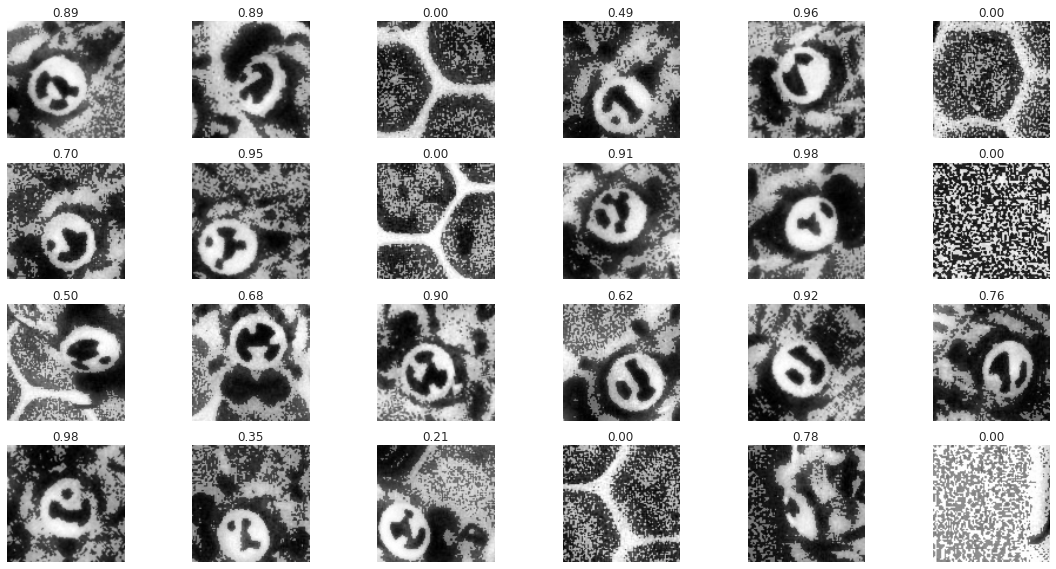

In [6]:
fig = visualization.plot_sample_images(X_train, y_train, random=True)

In [7]:
Xs_train = util.resize_data(X_train, config.filtersize)
Xs_val   = util.resize_data(X_val, config.filtersize)
Xs_test  = util.resize_data(X_test, config.filtersize)

print(Xs_train.shape)
print(Xs_test.shape)
print(Xs_val.shape)

19456/18725 [===============================] - 33s   
(164529, 1, 32, 32)
(18725, 1, 32, 32)
(18725, 1, 32, 32)


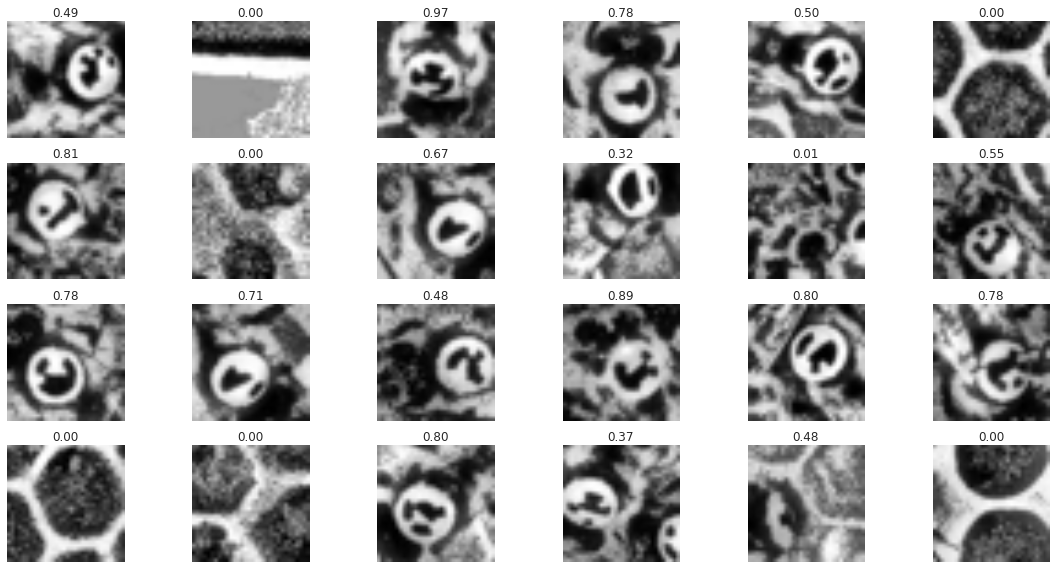

In [8]:
fig = visualization.plot_sample_images(Xs_train, y_train)

In [16]:
saliency_network = models.get_saliency_network(train=True, learning_rate=0.1)

In [17]:
saliency_datagen = keras_helpers.get_datagen(Xs_train)
saliency_class_weight = [1., 1.]
saliency_weight_file = join(expanduser("~"), 'saliency-localizer-models', 'season_2015', 'saliency_weights-wobn')

In [18]:
saliency_history = keras_helpers.fit_model(saliency_network, saliency_datagen, Xs_train, y_train, Xs_val, y_val,
                                           saliency_weight_file, saliency_class_weight, batchsize=128, categorial=False)

Epoch 0
18725/18725 [==============================] - 1s - test loss: 0.0148     

Epoch 1
18725/18725 [==============================] - 1s - test loss: 0.0121     

Epoch 2
18725/18725 [==============================] - 1s - test loss: 0.0117     

Epoch 3
18725/18725 [==============================] - 1s - test loss: 0.0114     

Epoch 4
18725/18725 [==============================] - 1s - test loss: 0.0093     

Epoch 5
18725/18725 [==============================] - 0s - test loss: 0.0085     

Epoch 6
18725/18725 [==============================] - 0s - test loss: 0.0081     

Epoch 7
18725/18725 [==============================] - 0s - test loss: 0.0081     

Epoch 8
18725/18725 [==============================] - 0s - test loss: 0.0079     

Epoch 9
18725/18725 [==============================] - 0s - test loss: 0.0075     

Epoch 10
18725/18725 [==============================] - 0s - test loss: 0.0076     

Epoch 11
18725/18725 [==============================] - 0s - test loss: 0.0

In [19]:
batch_error = np.array([hist[0] for hist in saliency_history.batch_hist])

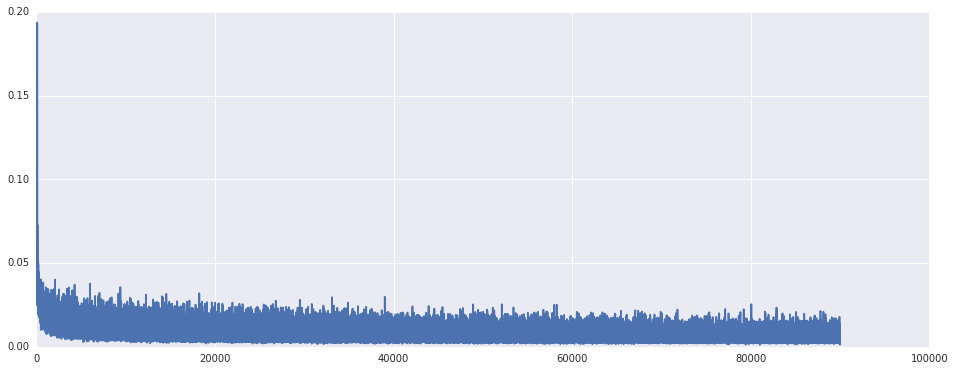

In [20]:
plt.figure(figsize=(16, 6))
_ = plt.plot(batch_error)

In [21]:
batch_error.shape[0] / (658145 / 256)

35.0152625941092

In [22]:
batch_error[-1]

0.001609749

In [23]:
saliency_network.load_weights(saliency_weight_file)

In [24]:
ys_out = keras_helpers.predict_model(saliency_network, Xs_test, saliency_datagen)

18944/18725 [==============================] - 0s     


In [25]:
max(ys_out[:, 1])

0.99953609704971313

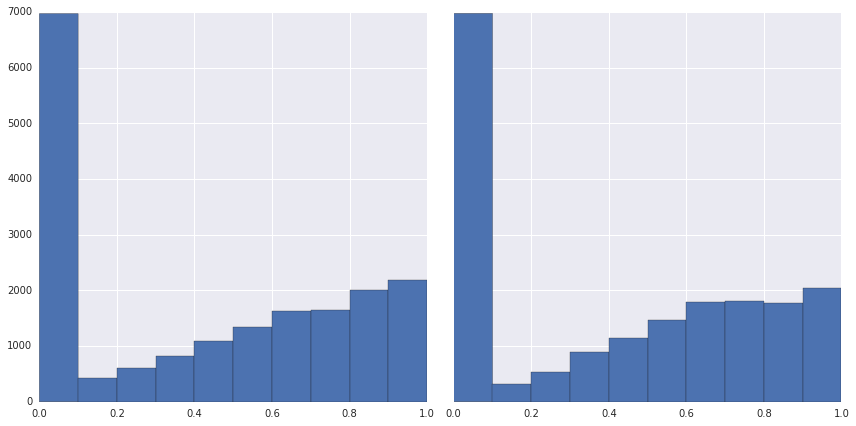

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 6))
axes.flat[0].hist(y_test[:])
axes.flat[1].hist(ys_out[:, 1])

plt.tight_layout()

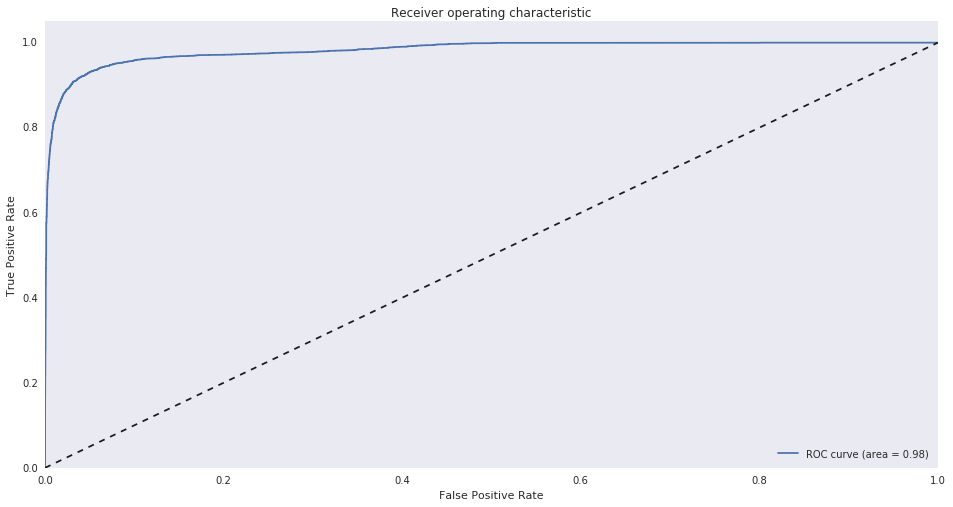

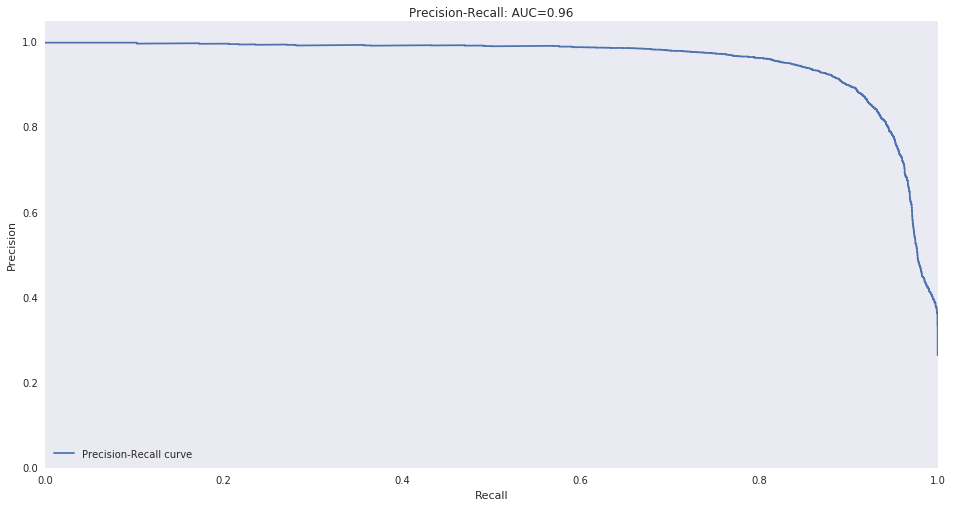

In [27]:
precision, recall, average_precision, thresholds, fpr, tpr, roc_auc = keras_helpers.evaluate_model(
    y_test > 0.8, ys_out, visualize=True)

In [28]:
saliency_threshold = keras_helpers.select_threshold(precision, recall, thresholds, min_value=0.98, optimize='recall')

('Recall', 0.98021454112038142)
('Precision', 0.47172192267982105)
('Threshold', 0.51229846477508545)
('F_2', 0.80636937678942622)
('F_0.5', 0.5263292629854337)


In [71]:
saliency_threshold = 0.5

In [41]:
saliency_convolution_model = models.get_saliency_network(train=False, shape=image_filtersize.shape)

In [42]:
convolution_function = keras_helpers.get_convolution_function(saliency_network, saliency_convolution_model)

In [43]:
image_path = join(expanduser("~"), 'deeplocalizer_data')
with open(join(image_path, 'test.txt'), 'r') as f:
    image_files = [line.split('\n')[0] for line in f.readlines()]

In [44]:
imfile = image_files[0]
image, image_filtersize, targetsize = util.preprocess_image(join(image_path, imfile), config.filtersize)

In [45]:
%%%timeit
convolution_function(image_filtersize.reshape((1, 1, image_filtersize.shape[0], image_filtersize.shape[1])))

The slowest run took 6.95 times longer than the fastest. This could mean that an intermediate result is being cached 
10 loops, best of 3: 25.3 ms per loop


In [46]:
saliency = convolution_function(image_filtersize.reshape((1, 1, image_filtersize.shape[0], image_filtersize.shape[1])))

In [49]:
from skimage.filters import gaussian_filter

In [50]:
saliency[0].shape

(1, 1, 952, 1272)

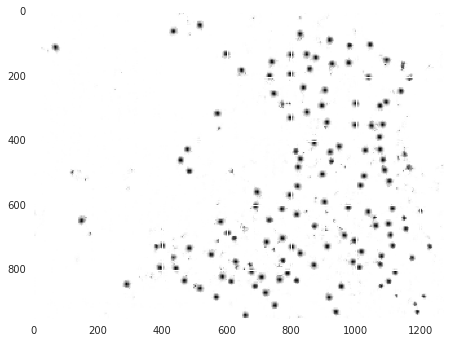

In [52]:
plt.imshow(saliency[0][0, 0])

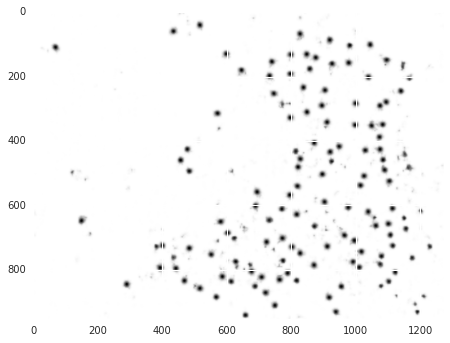

In [60]:
plt.imshow(gaussian_filter(saliency[0][0, 0], sigma=2.))

In [62]:
saliency[0][0, 0] = gaussian_filter(saliency[0][0, 0], sigma=2.)

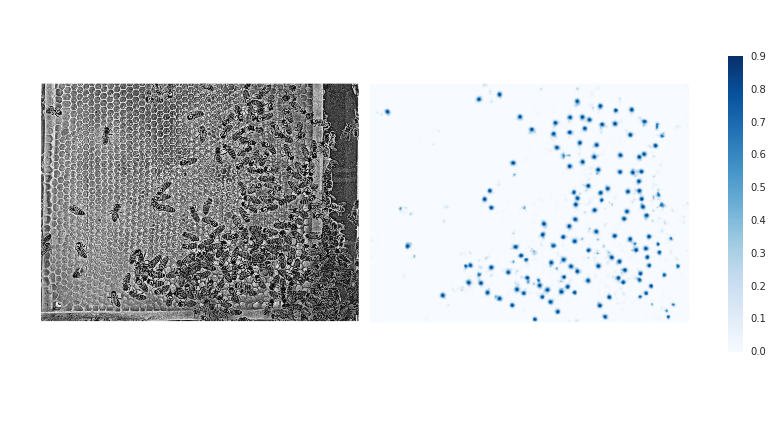

In [63]:
_ = visualization.plot_saliency_image(image_filtersize, saliency[0][0, 0], config.filtersize, figsize=(12, 6))

#plt.savefig('saliency.png', dpi=300, bbox_inches='tight')

In [72]:
candidates = util.get_candidates(saliency, saliency_threshold, dist=config.filtersize[0] / 4)

In [73]:
rois, saliencies = util.extract_rois(candidates, saliency, image)

In [74]:
len(candidates)

138

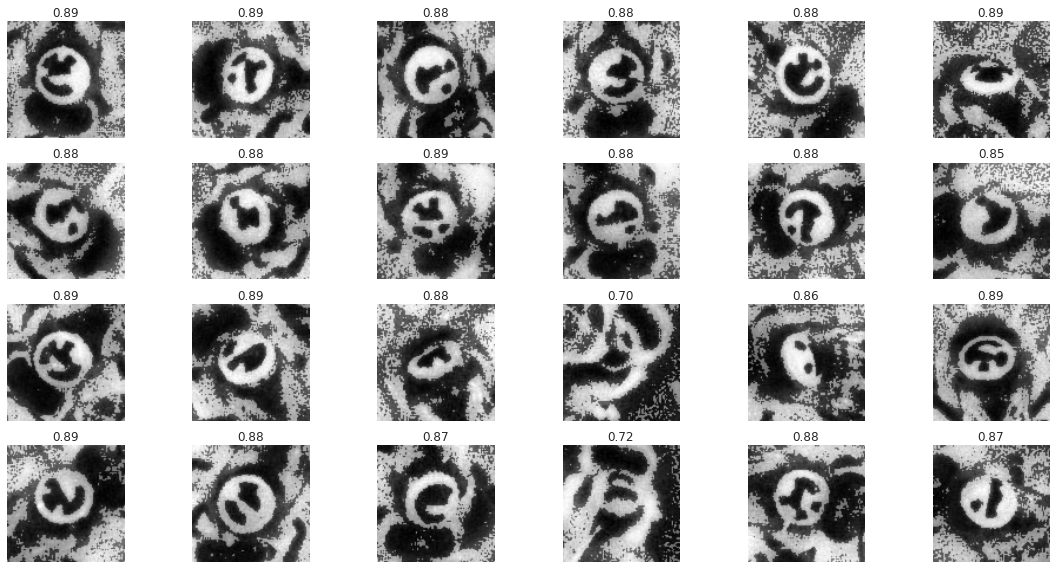

In [75]:
fig = visualization.plot_sample_images(rois, saliencies)

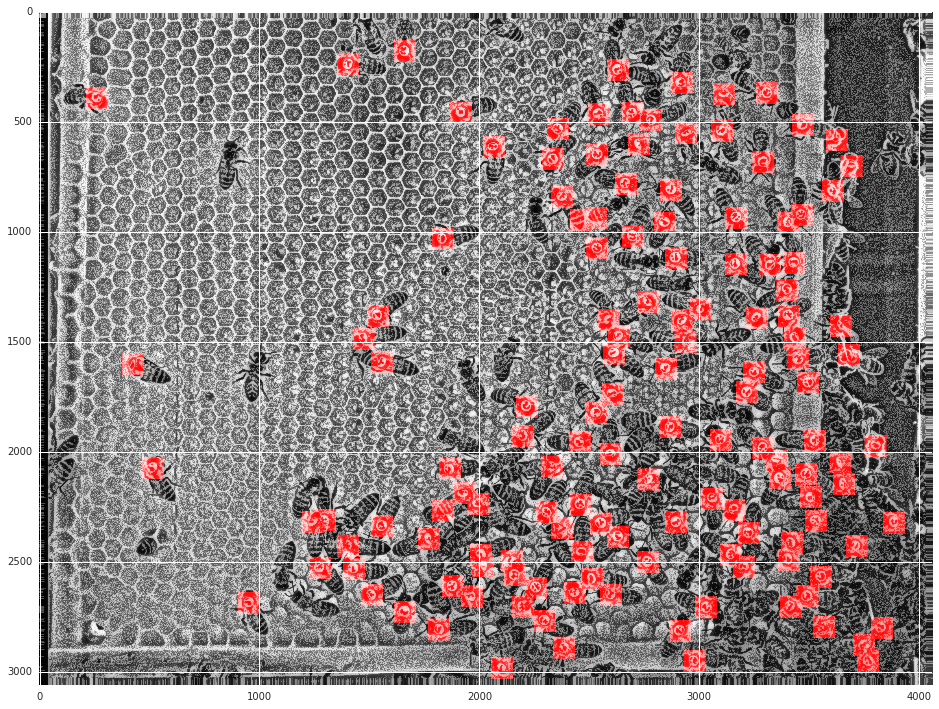

In [76]:
plt.figure(figsize=(16, 16))
_ = plt.imshow(visualization.get_roi_overlay(candidates, image))